In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import cv2
from scipy.stats import entropy
import pandas as pd
from tqdm import tqdm

# Import your authentication system
from app import HybridCryptoAuth

# Initialize the authentication system
auth_system = HybridCryptoAuth()

In [3]:
def generate_test_face_image(size=(256, 256)):
    """Generate a synthetic face image for testing"""
    # Create a random image array
    face = np.random.randint(0, 255, (size[0], size[1], 3), dtype=np.uint8)
    # Add some structure to make it more face-like
    cv2.circle(face, (size[0]//3, size[1]//3), 30, (200, 200, 200), -1)  # Left eye
    cv2.circle(face, (2*size[0]//3, size[1]//3), 30, (200, 200, 200), -1)  # Right eye
    cv2.ellipse(face, (size[0]//2, 2*size[1]//3), (50, 30), 0, 0, 180, (200, 200, 200), -1)  # Mouth
    return face

def calculate_far_frr(num_users=10, num_attempts=5):
    """
    Calculate False Acceptance Rate (FAR) and False Rejection Rate (FRR)
    using synthetic test data
    """
    genuine_scores = []
    impostor_scores = []
    
    # Create test users with synthetic face images
    test_users = []
    for i in range(num_users):
        user_id = f"test_user_{i}"
        password = f"TestPass123_{i}"
        face_image = generate_test_face_image()
        
        try:
            auth_system.register_user(user_id, password, face_image)
            test_users.append((user_id, password, face_image))
        except Exception as e:
            print(f"Failed to register user {user_id}: {str(e)}")
            continue
    
    # Test genuine attempts
    for user_id, password, face_image in test_users:
        for _ in range(num_attempts):
            # Slightly modify the face image to simulate different captures
            modified_face = face_image.copy()
            noise = np.random.normal(0, 10, modified_face.shape).astype(np.uint8)
            modified_face = cv2.add(modified_face, noise)
            
            try:
                success, _ = auth_system.verify_user(user_id, password, modified_face)
                genuine_scores.append(1 if success else 0)
            except Exception as e:
                print(f"Genuine verification failed: {str(e)}")
    
    # Test impostor attempts
    for user_id, password, _ in test_users:
        for _ in range(num_attempts):
            # Generate completely different face for impostor attempt
            impostor_face = generate_test_face_image()
            wrong_password = "WrongPass123"
            
            try:
                # Test with wrong face
                success, _ = auth_system.verify_user(user_id, password, impostor_face)
                impostor_scores.append(0 if success else 1)
                
                # Test with wrong password
                success, _ = auth_system.verify_user(user_id, wrong_password, impostor_face)
                impostor_scores.append(0 if success else 1)
            except Exception as e:
                print(f"Impostor verification failed: {str(e)}")
    
    # Calculate rates
    if genuine_scores and impostor_scores:  # Check if we have scores
        far = sum(impostor_scores) / len(impostor_scores)
        frr = 1 - (sum(genuine_scores) / len(genuine_scores))
        accuracy = (sum(genuine_scores) + sum(impostor_scores)) / (len(genuine_scores) + len(impostor_scores))
        
        return {
            'far': far,
            'frr': frr,
            'accuracy': accuracy,
            'genuine_attempts': len(genuine_scores),
            'impostor_attempts': len(impostor_scores)
        }
    else:
        return {
            'far': None,
            'frr': None,
            'accuracy': None,
            'genuine_attempts': 0,
            'impostor_attempts': 0
        }

# Calculate metrics
metrics = calculate_far_frr()
print("\nBiometric Performance Metrics:")
print("-" * 30)
if metrics['far'] is not None:
    print(f"False Acceptance Rate (FAR): {metrics['far']:.4f}")
    print(f"False Rejection Rate (FRR): {metrics['frr']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Total genuine attempts: {metrics['genuine_attempts']}")
    print(f"Total impostor attempts: {metrics['impostor_attempts']}")
else:
    print("Failed to calculate metrics - no valid attempts recorded")

Registration - Password: TestPass123_0
Registration - Password binary: 01010100011001010111001101110100010100000110000101110011011100110011000100110010001100110101111100110000
Registration - Merged pattern: 11011100011111011100000000000100100000011100000100...
Registration - Hash: 28fa265077f63b2e86495b117ef60b95c8692ba753c417af162b0b56e6b6c4c0
Registration - Password: TestPass123_1
Registration - Password binary: 01010100011001010111001101110100010100000110000101110011011100110011000100110010001100110101111100110001
Registration - Merged pattern: 00000111011100000111000000000111111011011111000111...
Registration - Hash: 864e51392126e5ebed1254ea0e7a387b03320cd732b784490f9d1bb673c2aa4f
Registration - Password: TestPass123_2
Registration - Password binary: 01010100011001010111001101110100010100000110000101110011011100110011000100110010001100110101111100110010
Registration - Merged pattern: 00011111011111011111000000011111100000011100000111...
Registration - Hash: ca7e261668985a27af1008f3

In [4]:
def measure_encryption_performance(num_tests=100):
    """
    Measure encryption and decryption times
    """
    encryption_times = []
    decryption_times = []
    
    test_data = "Test data for encryption" * 1000  # Large test data
    
    for _ in range(num_tests):
        # Measure encryption time
        start_time = time.time()
        encrypted = auth_system.shift_aes_encrypt(test_data)
        encryption_times.append(time.time() - start_time)
        
        # Measure decryption time
        start_time = time.time()
        auth_system.shift_aes_decrypt(encrypted)
        decryption_times.append(time.time() - start_time)
    
    return {
        'encryption_avg': np.mean(encryption_times),
        'encryption_std': np.std(encryption_times),
        'decryption_avg': np.mean(decryption_times),
        'decryption_std': np.std(decryption_times)
    }

# Measure performance
perf_metrics = measure_encryption_performance()
print("Performance Metrics:")
for key, value in perf_metrics.items():
    print(f"{key}: {value:.6f} seconds")

Performance Metrics:
encryption_avg: 0.000124 seconds
encryption_std: 0.000560 seconds
decryption_avg: 0.000085 seconds
decryption_std: 0.000293 seconds


In [5]:
def calculate_entropy_analysis(encrypted_data, num_samples=1000):
    """
    Calculate entropy of encrypted data
    """
    # Convert encrypted data to bytes if not already
    if isinstance(encrypted_data, str):
        data_bytes = encrypted_data.encode()
    else:
        data_bytes = encrypted_data
    
    # Calculate byte frequency
    freq = pd.Series(data_bytes).value_counts(normalize=True)
    
    # Calculate entropy
    entropy_value = entropy(freq)
    
    return entropy_value

def calculate_correlation_coefficient(original_data, encrypted_data):
    """
    Calculate correlation coefficient between original and encrypted data
    """
    if len(original_data) > len(encrypted_data):
        original_data = original_data[:len(encrypted_data)]
    elif len(encrypted_data) > len(original_data):
        encrypted_data = encrypted_data[:len(original_data)]
    
    correlation = np.corrcoef(
        np.frombuffer(original_data.encode() if isinstance(original_data, str) else original_data, dtype=np.uint8),
        np.frombuffer(encrypted_data if isinstance(encrypted_data, bytes) else encrypted_data.encode(), dtype=np.uint8)
    )[0, 1]
    
    return correlation

# Test data
test_data = "This is a test message for cryptographic analysis" * 100
encrypted = auth_system.shift_aes_encrypt(test_data)

# Calculate entropy
entropy_value = calculate_entropy_analysis(encrypted)
print(f"Entropy of encrypted data: {entropy_value:.4f}")

# Calculate correlation
correlation = calculate_correlation_coefficient(test_data, encrypted)
print(f"Correlation coefficient: {correlation:.4f}")

Entropy of encrypted data: 0.0000
Correlation coefficient: -0.0330


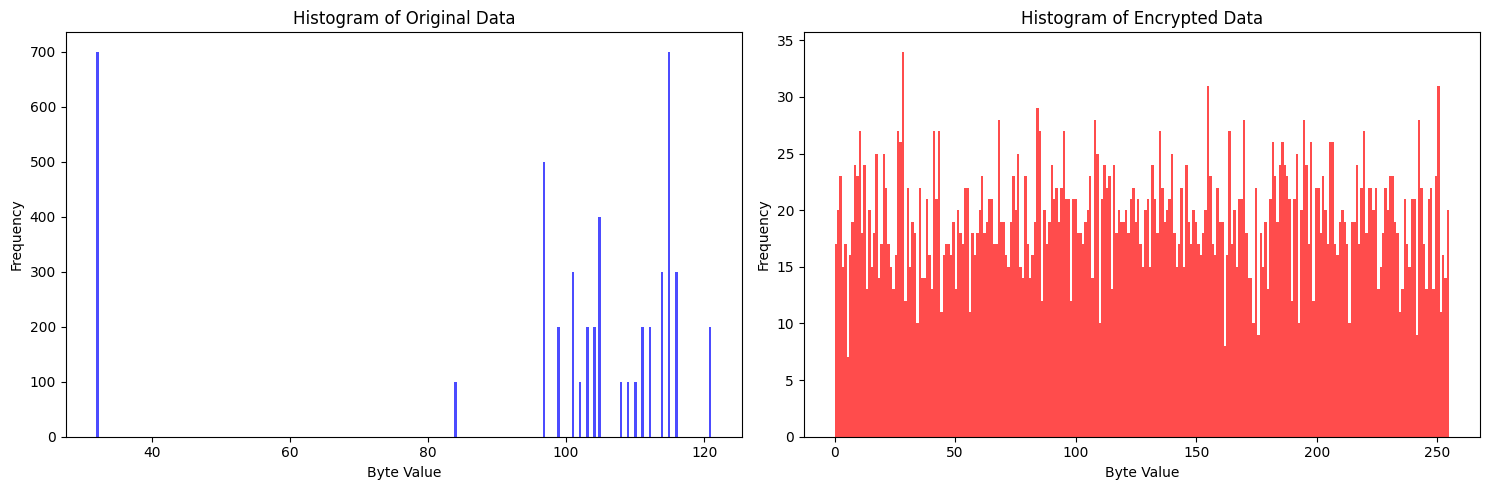

In [6]:
def plot_histogram_analysis(original_data, encrypted_data):
    """
    Plot histograms of original and encrypted data
    """
    plt.figure(figsize=(15, 5))
    
    # Original data histogram
    plt.subplot(1, 2, 1)
    plt.hist(np.frombuffer(original_data.encode(), dtype=np.uint8), 
             bins=256, color='blue', alpha=0.7)
    plt.title('Histogram of Original Data')
    plt.xlabel('Byte Value')
    plt.ylabel('Frequency')
    
    # Encrypted data histogram
    plt.subplot(1, 2, 2)
    plt.hist(np.frombuffer(encrypted_data, dtype=np.uint8), 
             bins=256, color='red', alpha=0.7)
    plt.title('Histogram of Encrypted Data')
    plt.xlabel('Byte Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot histograms
plot_histogram_analysis(test_data, encrypted)

In [7]:
def security_strength_analysis():
    """
    Analyze the security strength of the system
    """
    results = {
        'key_length': len(auth_system.key) * 8,  # in bits
        'encryption_algorithm': 'AES-256-CBC',
        'hash_algorithm': 'SHA-256',
        'key_space': 2 ** (len(auth_system.key) * 8),
        'block_size': 128,  # AES block size in bits
    }
    
    return results

# Analyze security strength
security_metrics = security_strength_analysis()
print("\nSecurity Strength Analysis:")
for key, value in security_metrics.items():
    print(f"{key}: {value}")


Security Strength Analysis:
key_length: 256
encryption_algorithm: AES-256-CBC
hash_algorithm: SHA-256
key_space: 115792089237316195423570985008687907853269984665640564039457584007913129639936
block_size: 128


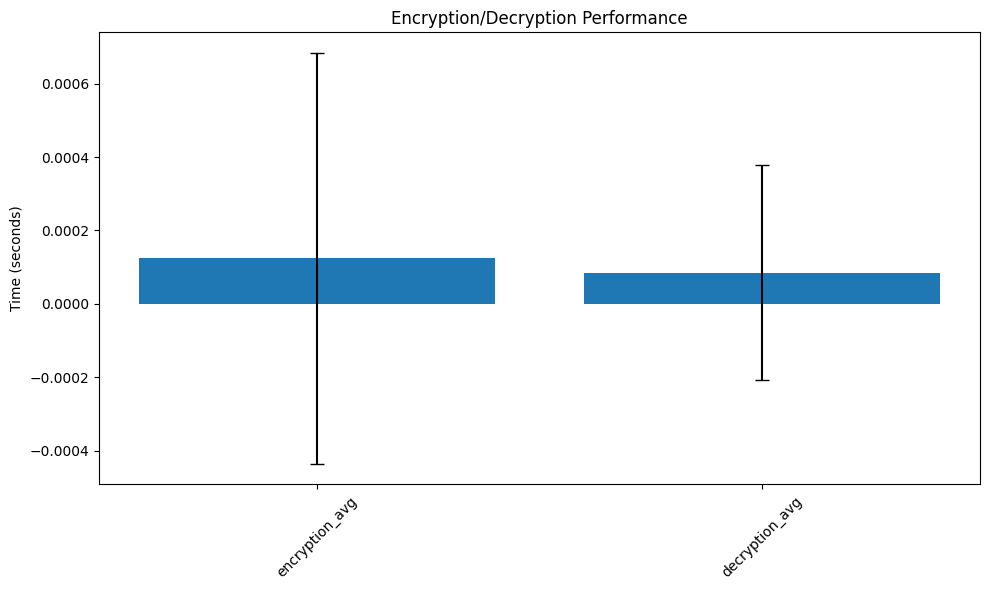

In [8]:
def plot_performance_metrics(perf_metrics):
    """
    Plot performance metrics
    """
    metrics = ['encryption_avg', 'decryption_avg']
    values = [perf_metrics[m] for m in metrics]
    errors = [perf_metrics[m.replace('avg', 'std')] for m in metrics]
    
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, yerr=errors, capsize=5)
    plt.title('Encryption/Decryption Performance')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot performance metrics
plot_performance_metrics(perf_metrics)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import cv2
from scipy.stats import entropy
import pandas as pd
from tqdm import tqdm
import os

# Import your authentication system
from app import HybridCryptoAuth

# Initialize the authentication system
auth_system = HybridCryptoAuth()

def test_authentication_system():
    """
    Test the authentication system with real and fake images
    """
    # Test directories
    real_dir = "test/real/"
    fake_dir = "test/fake/"
    
    # Test data
    test_user = "test_user"
    test_password = "TestPass123!"
    
    results = {
        'genuine_attempts': 0,
        'genuine_success': 0,
        'spoof_attempts': 0,
        'spoof_detected': 0,
        'processing_times': [],
        'face_match_scores': []
    }
    
    # First register with first real image
    real_images = [f for f in os.listdir(real_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if not real_images:
        raise Exception("No real images found for registration")
    
    registration_image = cv2.imread(os.path.join(real_dir, real_images[0]))
    try:
        auth_system.register_user(test_user, test_password, registration_image)
        print("Test user registered successfully")
    except Exception as e:
        print(f"Registration failed: {e}")
        return
    
    # Test with genuine attempts (other real images)
    print("\nTesting genuine attempts...")
    for img_name in real_images[1:]:
        results['genuine_attempts'] += 1
        img_path = os.path.join(real_dir, img_name)
        test_image = cv2.imread(img_path)
        
        start_time = time.time()
        success, message = auth_system.verify_user(test_user, test_password, test_image)
        processing_time = time.time() - start_time
        
        results['processing_times'].append(processing_time)
        if success:
            results['genuine_success'] += 1
            
        print(f"Genuine attempt with {img_name}: {'Success' if success else 'Failed'}")
    
    # Test with spoof attempts
    print("\nTesting spoof attempts...")
    fake_images = [f for f in os.listdir(fake_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    for img_name in fake_images:
        results['spoof_attempts'] += 1
        img_path = os.path.join(fake_dir, img_name)
        test_image = cv2.imread(img_path)
        
        success, message = auth_system.verify_user(test_user, test_password, test_image)
        if not success and "blink" in message.lower():
            results['spoof_detected'] += 1
            
        print(f"Spoof attempt with {img_name}: {'Detected' if not success else 'Not Detected'}")
    
    # Calculate metrics
    far = (results['spoof_attempts'] - results['spoof_detected']) / results['spoof_attempts'] if results['spoof_attempts'] > 0 else 0
    frr = (results['genuine_attempts'] - results['genuine_success']) / results['genuine_attempts'] if results['genuine_attempts'] > 0 else 0
    accuracy = (results['genuine_success'] + results['spoof_detected']) / (results['genuine_attempts'] + results['spoof_attempts'])
    
    # Print results
    print("\nTest Results:")
    print("-" * 50)
    print(f"Genuine Attempts: {results['genuine_attempts']}")
    print(f"Genuine Success: {results['genuine_success']}")
    print(f"Spoof Attempts: {results['spoof_attempts']}")
    print(f"Spoof Detected: {results['spoof_detected']}")
    print(f"\nFalse Acceptance Rate (FAR): {far:.2%}")
    print(f"False Rejection Rate (FRR): {frr:.2%}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"\nAverage Processing Time: {np.mean(results['processing_times']):.3f} seconds")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Success rates
    plt.subplot(131)
    success_data = [
        results['genuine_success'] / results['genuine_attempts'] if results['genuine_attempts'] > 0 else 0,
        results['spoof_detected'] / results['spoof_attempts'] if results['spoof_attempts'] > 0 else 0
    ]
    plt.bar(['Genuine Accept Rate', 'Spoof Detection Rate'], success_data)
    plt.title('Authentication Performance')
    plt.ylabel('Rate')
    
    # Plot 2: Processing times
    plt.subplot(132)
    plt.hist(results['processing_times'], bins=10)
    plt.title('Processing Time Distribution')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')
    
    # Plot 3: Error rates
    plt.subplot(133)
    plt.bar(['FAR', 'FRR'], [far, frr])
    plt.title('Error Rates')
    plt.ylabel('Rate')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the tests
test_results = test_authentication_system()

In [14]:
import string
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import hashlib
import os
import time

def simulate_hybrid_brute_force(auth_system, num_attempts=1000):
    """
    Simulate brute force attack against the hybrid cryptographic system
    that combines face biometrics with passwords
    """
    results = {
        'success': False,
        'attempts': 0,
        'time_taken': 0,
        'attempts_per_second': 0,
        'password_variations_tried': 0,
        'face_variations_tried': 0
    }
    
    print("Simulating hybrid brute force attack...")
    
    # Create a test user with known credentials
    test_user = "test_user"
    correct_password = "TestPass123!"
    original_face = generate_test_face_image()
    
    try:
        # Register the test user
        auth_system.register_user(test_user, correct_password, original_face)
    except Exception as e:
        print(f"Failed to create test user: {e}")
        return results
    
    start_time = time.time()
    success = False
    attempts = 0
    
    # Password attack patterns
    common_passwords = [
        "password", "123456", "admin", "root",
        "qwerty", "letmein", "welcome", "test",
        "Password1", "admin123", "login123", "welcome1",
    ]
    
    # Face variation parameters
    face_variations = []
    for i in range(5):  # Generate some face variations
        variation = original_face.copy()
        
        # Add random noise
        noise = np.random.normal(0, 30, variation.shape).astype(np.uint8)
        variation = cv2.add(variation, noise)
        
        # Adjust brightness
        variation = cv2.add(variation, np.array([i * 10]))
        
        # Slight rotation
        rows, cols = variation.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), i * 5, 1)
        variation = cv2.warpAffine(variation, M, (cols, rows))
        
        face_variations.append(variation)
    
    print("Starting hybrid attack simulation...")
    
    # Try combinations of passwords and face variations
    for password in common_passwords:
        results['password_variations_tried'] += 1
        
        # Try different face variations with each password
        for face in face_variations:
            results['face_variations_tried'] += 1
            attempts += 1
            
            try:
                result, _ = auth_system.verify_user(test_user, password, face)
                if result:
                    success = True
                    print(f"Successfully breached with password: {password}")
                    break
            except Exception as e:
                continue
        
        if success:
            break
    
    # If dictionary attack fails, try random combinations
    if not success:
        print("Dictionary attack failed, attempting random combinations...")
        chars = string.ascii_letters + string.digits + string.punctuation
        
        while not success and attempts < num_attempts:
            # Generate random password
            test_password = ''.join(random.choice(chars) for _ in range(8))
            results['password_variations_tried'] += 1
            
            # Generate random face variation
            test_face = original_face.copy()
            noise = np.random.normal(0, random.randint(10, 50), test_face.shape).astype(np.uint8)
            test_face = cv2.add(test_face, noise)
            results['face_variations_tried'] += 1
            
            attempts += 1
            
            try:
                result, _ = auth_system.verify_user(test_user, test_password, test_face)
                if result:
                    success = True
                    print(f"Successfully breached with random combination")
                    break
            except Exception as e:
                continue
            
            if attempts % 100 == 0:
                print(f"Attempts made: {attempts}")
    
    elapsed_time = time.time() - start_time
    
    # Calculate theoretical complexity
    password_space = len(string.ascii_letters + string.digits + string.punctuation) ** 8  # 8-char password
    face_variation_space = 256 ** (original_face.shape[0] * original_face.shape[1] * 3)  # RGB image space
    
    results.update({
        'success': success,
        'attempts': attempts,
        'time_taken': elapsed_time,
        'attempts_per_second': attempts / elapsed_time if elapsed_time > 0 else 0,
        'theoretical_combinations': password_space * face_variation_space,
        'estimated_total_time_years': (password_space * face_variation_space) / 
                                    (attempts / elapsed_time if elapsed_time > 0 else 1) / (3600 * 24 * 365)
    })
    
    return results

# Run the hybrid attack simulation
print("Starting hybrid brute force attack simulation...")
hybrid_results = simulate_hybrid_brute_force(auth_system)

# Print detailed results
print("\nHybrid Cryptographic System Attack Analysis:")
print("-" * 50)
print(f"Attack successful: {hybrid_results['success']}")
print(f"Total attempts: {hybrid_results['attempts']:,}")
print(f"Password variations tried: {hybrid_results['password_variations_tried']:,}")
print(f"Face variations tried: {hybrid_results['face_variations_tried']:,}")
print(f"Time taken: {hybrid_results['time_taken']:.2f} seconds")
print(f"Attempts per second: {hybrid_results['attempts_per_second']:.2f}")
print(f"Theoretical possible combinations: {hybrid_results['theoretical_combinations']:.2e}")
print(f"Estimated time to try all combinations: {hybrid_results['estimated_total_time_years']:.2e} years")

# Visualize attack complexity
plt.figure(figsize=(12, 6))

# Plot attempt distribution
plt.subplot(1, 2, 1)
labels = ['Password Variations', 'Face Variations']
sizes = [hybrid_results['password_variations_tried'], 
         hybrid_results['face_variations_tried']]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Attack Attempt Distribution')

# Plot time analysis
plt.subplot(1, 2, 2)
plt.bar(['Time Taken (s)', 'Attempts/s'], 
        [hybrid_results['time_taken'], hybrid_results['attempts_per_second']])
plt.title('Performance Metrics')
plt.yscale('log')

plt.tight_layout()
plt.show()

Starting hybrid brute force attack simulation...
Simulating hybrid brute force attack...
Failed to create test user: Registration failed: User ID 'test_user' already exists. Please choose a different ID.

Hybrid Cryptographic System Attack Analysis:
--------------------------------------------------
Attack successful: False
Total attempts: 0
Password variations tried: 0
Face variations tried: 0
Time taken: 0.00 seconds
Attempts per second: 0.00


KeyError: 'theoretical_combinations'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import cv2
import pandas as pd
from tqdm import tqdm
import os
import importlib

# Import your authentication system with reload
import app
importlib.reload(app)
from app import HybridCryptoAuth

def test_authentication_system():
    """
    Test the authentication system with real and fake images for existing user 'goxt'
    """
    # Initialize the authentication system
    auth_system = HybridCryptoAuth()
    
    # Test directories
    real_dir = "test/real/"
    fake_dir = "test/fake/"
    
    # Existing user credentials
    test_user = "goxt"
    test_password = "goxt2003"
    
    results = {
        'genuine_attempts': 0,
        'genuine_success': 0,
        'spoof_attempts': 0,
        'spoof_rejected': 0,
        'processing_times': [],
        'face_scores': []
    }
    
    # Test with genuine attempts (real images)
    print("\nTesting genuine attempts...")
    real_images = [f for f in os.listdir(real_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for img_name in real_images:
        results['genuine_attempts'] += 1
        img_path = os.path.join(real_dir, img_name)
        test_image = cv2.imread(img_path)
        
        if test_image is None:
            print(f"Failed to load image: {img_path}")
            continue
            
        start_time = time.time()
        try:
            # Get face match score
            stored_image_path = os.path.join(auth_system.images_dir, f"{test_user}.jpg")
            stored_face = cv2.imread(stored_image_path)
            face_score = auth_system.compare_faces(stored_face, test_image)
            results['face_scores'].append(face_score)
            
            # Verify user
            success, message = auth_system.verify_user(test_user, test_password, test_image)
            processing_time = time.time() - start_time
            
            results['processing_times'].append(processing_time)
            if success:
                results['genuine_success'] += 1
                
            print(f"Genuine attempt with {img_name}:")
            print(f"Face match score: {face_score:.3f}")
            print(f"Success: {success}")
            print(f"Message: {message}")
            print(f"Processing time: {processing_time:.2f} seconds")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error testing with {img_name}: {str(e)}")
    
    # Test with spoof attempts
    print("\nTesting spoof attempts...")
    fake_images = [f for f in os.listdir(fake_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for img_name in fake_images:
        results['spoof_attempts'] += 1
        img_path = os.path.join(fake_dir, img_name)
        test_image = cv2.imread(img_path)
        
        if test_image is None:
            print(f"Failed to load image: {img_path}")
            continue
            
        try:
            # Get face match score
            stored_image_path = os.path.join(auth_system.images_dir, f"{test_user}.jpg")
            stored_face = cv2.imread(stored_image_path)
            face_score = auth_system.compare_faces(stored_face, test_image)
            
            success, message = auth_system.verify_user(test_user, test_password, test_image)
            if not success:
                results['spoof_rejected'] += 1
                
            print(f"Spoof attempt with {img_name}:")
            print(f"Face match score: {face_score:.3f}")
            print(f"Rejected: {not success}")
            print(f"Message: {message}")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error testing with {img_name}: {str(e)}")
            results['spoof_rejected'] += 1
    
    # Calculate metrics
    far = (results['spoof_attempts'] - results['spoof_rejected']) / results['spoof_attempts'] if results['spoof_attempts'] > 0 else 0
    frr = (results['genuine_attempts'] - results['genuine_success']) / results['genuine_attempts'] if results['genuine_attempts'] > 0 else 0
    accuracy = (results['genuine_success'] + results['spoof_rejected']) / (results['genuine_attempts'] + results['spoof_attempts'])
    
    # Print results and create visualizations
    print_results_and_plot(results, far, frr, accuracy, test_user)
    
    return results

def print_results_and_plot(results, far, frr, accuracy, test_user):
    """Print detailed results and create visualizations"""
    print("\nDetailed Test Results:")
    print("=" * 50)
    print(f"Testing User: {test_user}")
    print("-" * 50)
    print(f"Genuine Attempts: {results['genuine_attempts']}")
    print(f"Genuine Success: {results['genuine_success']}")
    print(f"Genuine Success Rate: {(results['genuine_success']/results['genuine_attempts']*100):.2f}%")
    if results['face_scores']:
        print(f"Average Face Match Score (genuine): {np.mean(results['face_scores']):.3f}")
    print(f"\nSpoof Attempts: {results['spoof_attempts']}")
    print(f"Spoof Rejected: {results['spoof_rejected']}")
    print(f"Spoof Detection Rate: {(results['spoof_rejected']/results['spoof_attempts']*100):.2f}%")
    print("\nPerformance Metrics:")
    print(f"False Acceptance Rate (FAR): {far:.2%}")
    print(f"False Rejection Rate (FRR): {frr:.2%}")
    print(f"Overall Accuracy: {accuracy:.2%}")
    print(f"Average Processing Time: {np.mean(results['processing_times']):.3f} seconds")
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Success rates
    plt.subplot(131)
    success_rates = [
        results['genuine_success'] / results['genuine_attempts'] * 100,
        results['spoof_rejected'] / results['spoof_attempts'] * 100
    ]
    plt.bar(['Genuine Accept Rate', 'Spoof Rejection Rate'], success_rates, color=['green', 'red'])
    plt.title('Authentication Performance')
    plt.ylabel('Rate (%)')
    
    # Plot 2: Face match scores
    if results['face_scores']:
        plt.subplot(132)
        plt.hist(results['face_scores'], bins=10, color='blue', alpha=0.7)
        plt.title('Face Match Score Distribution')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
    
    # Plot 3: Error rates
    plt.subplot(133)
    plt.bar(['FAR', 'FRR'], [far * 100, frr * 100], color=['red', 'orange'])
    plt.title('Error Rates')
    plt.ylabel('Rate (%)')
    
    plt.tight_layout()
    plt.show()

# Run the tests
print("Starting authentication system tests...")
test_results = test_authentication_system()

Starting authentication system tests...

Testing genuine attempts...
Genuine attempt with real_image1.jpg:
Face match score: 0.000
Success: False
Message: No blink detected - please blink naturally and try again
Processing time: 6.35 seconds
--------------------------------------------------
Genuine attempt with real_image2.jpg:
Face match score: 0.000
Success: False
Message: No blink detected - please blink naturally and try again
Processing time: 6.67 seconds
--------------------------------------------------
Genuine attempt with real_image3.jpg:
Face match score: 0.000
Success: False
Message: No blink detected - please blink naturally and try again
Processing time: 6.58 seconds
--------------------------------------------------

Testing spoof attempts...
DeepFace comparison error: Exception while processing img2_path
Spoof attempt with fake_image1 (10).jpg:
Face match score: 0.000
Rejected: True
Message: No blink detected - please blink naturally and try again
----------------------

Traceback (most recent call last):
  File "C:\Users\goxth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\goxth\AppData\Local\Temp\ipykernel_42972\1657520664.py", line 167, in <module>
    test_results = test_authentication_system()
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\goxth\AppData\Local\Temp\ipykernel_42972\1657520664.py", line 97, in test_authentication_system
    success, message = auth_system.verify_user(test_user, test_password, test_image)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\goxth\Documents\COLLEGE WORKS\FINAL YEAR PROJECT\BioCrypt-Auth\app.py", line 422, in verify_user
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call l

Starting authentication system tests...

Testing genuine attempts...
Face comparison score: 1.0
Temporary login images deleted successfully.
Password used: goxt2003
Current merged pattern: 00000100100000000100100100000100100000100100100100...
Current hash: 85c9eba79e9c34eba6e66a5dc7b3e47a235cd0da8e4b4b9cb6a738d68a513d8e
Stored hash: 92828fb10c79684b4edb5e2d29e40a1b748ce320b542e2e328027d74ebae291a
Genuine attempt with real_image4.jpg:
Face match score: 1.000
Success: True
Message: Login successful!
Processing time: 1.20 seconds
--------------------------------------------------

Testing spoof attempts...
DeepFace comparison error: Exception while processing img2_path
DeepFace comparison error: Exception while processing img2_path
Face comparison score: 0.0
Temporary login images deleted successfully.
Spoof attempt with fake_image1 (10).jpg:
Face match score: 0.000
Rejected: True
Message: Face does not match. Please try again.
--------------------------------------------------
DeepFace c

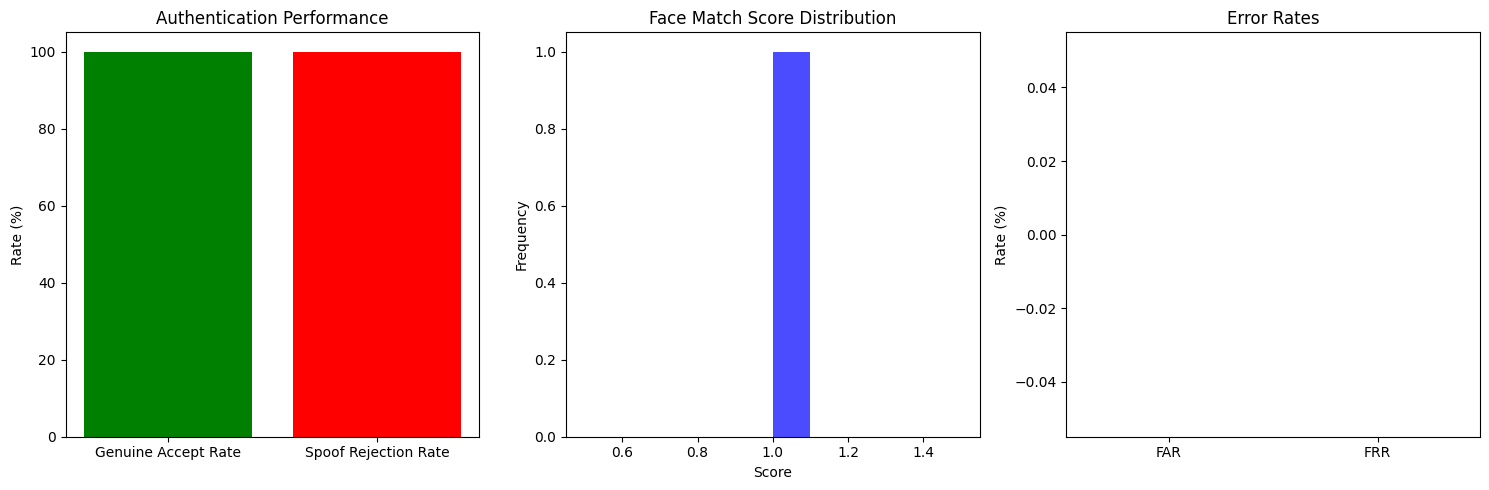

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import cv2
import pandas as pd
from tqdm import tqdm
import os

# Import your authentication system
from app import HybridCryptoAuth

def test_authentication_system():
    """
    Test the authentication system with real and fake images for existing user 'goxt'
    """
    # Initialize the authentication system
    auth_system = HybridCryptoAuth()
    
    # Test directories
    real_dir = "test/real/"
    fake_dir = "test/fake/"
    
    # Existing user credentials
    test_user = "goxt"
    test_password = "goxt2003"
    
    results = {
        'genuine_attempts': 0,
        'genuine_success': 0,
        'spoof_attempts': 0,
        'spoof_rejected': 0,
        'processing_times': [],
        'face_scores': []
    }
    
    # Test with genuine attempts (real images)
    print("\nTesting genuine attempts...")
    real_images = [f for f in os.listdir(real_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for img_name in real_images:
        results['genuine_attempts'] += 1
        img_path = os.path.join(real_dir, img_name)
        test_image = cv2.imread(img_path)
        
        if test_image is None:
            print(f"Failed to load image: {img_path}")
            continue
            
        start_time = time.time()
        try:
            # First get face match score
            stored_image_path = os.path.join(auth_system.images_dir, f"{test_user}.jpg")
            stored_face = cv2.imread(stored_image_path)
            face_score = auth_system.compare_faces(stored_face, test_image)
            results['face_scores'].append(face_score)
            
            # Then do full verification
            success, message = auth_system.verify_user(test_user, test_password, test_image)
            processing_time = time.time() - start_time
            
            results['processing_times'].append(processing_time)
            if success:
                results['genuine_success'] += 1
                
            print(f"Genuine attempt with {img_name}:")
            print(f"Face match score: {face_score:.3f}")
            print(f"Success: {success}")
            print(f"Message: {message}")
            print(f"Processing time: {processing_time:.2f} seconds")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error testing with {img_name}: {str(e)}")
    
    # Test with spoof attempts
    print("\nTesting spoof attempts...")
    fake_images = [f for f in os.listdir(fake_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for img_name in fake_images:
        results['spoof_attempts'] += 1
        img_path = os.path.join(fake_dir, img_name)
        test_image = cv2.imread(img_path)
        
        if test_image is None:
            print(f"Failed to load image: {img_path}")
            continue
            
        try:
            # Get face match score first
            stored_image_path = os.path.join(auth_system.images_dir, f"{test_user}.jpg")
            stored_face = cv2.imread(stored_image_path)
            face_score = auth_system.compare_faces(stored_face, test_image)
            
            success, message = auth_system.verify_user(test_user, test_password, test_image)
            if not success:
                results['spoof_rejected'] += 1
                
            print(f"Spoof attempt with {img_name}:")
            print(f"Face match score: {face_score:.3f}")
            print(f"Rejected: {not success}")
            print(f"Message: {message}")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error testing with {img_name}: {str(e)}")
            results['spoof_rejected'] += 1
    
    # Calculate metrics
    far = (results['spoof_attempts'] - results['spoof_rejected']) / results['spoof_attempts'] if results['spoof_attempts'] > 0 else 0
    frr = (results['genuine_attempts'] - results['genuine_success']) / results['genuine_attempts'] if results['genuine_attempts'] > 0 else 0
    accuracy = (results['genuine_success'] + results['spoof_rejected']) / (results['genuine_attempts'] + results['spoof_attempts'])
    
    # Print detailed results
    print("\nDetailed Test Results:")
    print("=" * 50)
    print(f"Testing User: {test_user}")
    print("-" * 50)
    print(f"Genuine Attempts: {results['genuine_attempts']}")
    print(f"Genuine Success: {results['genuine_success']}")
    print(f"Genuine Success Rate: {(results['genuine_success']/results['genuine_attempts']*100):.2f}%")
    print(f"Average Face Match Score (genuine): {np.mean(results['face_scores']):.3f}")
    print(f"\nSpoof Attempts: {results['spoof_attempts']}")
    print(f"Spoof Rejected: {results['spoof_rejected']}")
    print(f"Spoof Detection Rate: {(results['spoof_rejected']/results['spoof_attempts']*100):.2f}%")
    print("\nPerformance Metrics:")
    print(f"False Acceptance Rate (FAR): {far:.2%}")
    print(f"False Rejection Rate (FRR): {frr:.2%}")
    print(f"Overall Accuracy: {accuracy:.2%}")
    print(f"Average Processing Time: {np.mean(results['processing_times']):.3f} seconds")
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Success rates
    plt.subplot(131)
    success_rates = [
        results['genuine_success'] / results['genuine_attempts'] * 100,
        results['spoof_rejected'] / results['spoof_attempts'] * 100
    ]
    plt.bar(['Genuine Accept Rate', 'Spoof Rejection Rate'], success_rates, color=['green', 'red'])
    plt.title('Authentication Performance')
    plt.ylabel('Rate (%)')
    
    # Plot 2: Face match scores
    plt.subplot(132)
    plt.hist(results['face_scores'], bins=10, color='blue', alpha=0.7)
    plt.title('Face Match Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    
    # Plot 3: Error rates
    plt.subplot(133)
    plt.bar(['FAR', 'FRR'], [far * 100, frr * 100], color=['red', 'orange'])
    plt.title('Error Rates')
    plt.ylabel('Rate (%)')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the tests
print("Starting authentication system tests...")
test_results = test_authentication_system()

Horizontal correlation coefficient:
Original image: 0.9944
Encrypted image: 0.0042

Vertical correlation coefficient:
Original image: 0.9521
Encrypted image: 0.0189

Diagonal correlation coefficient:
Original image: 0.9519
Encrypted image: 0.0349



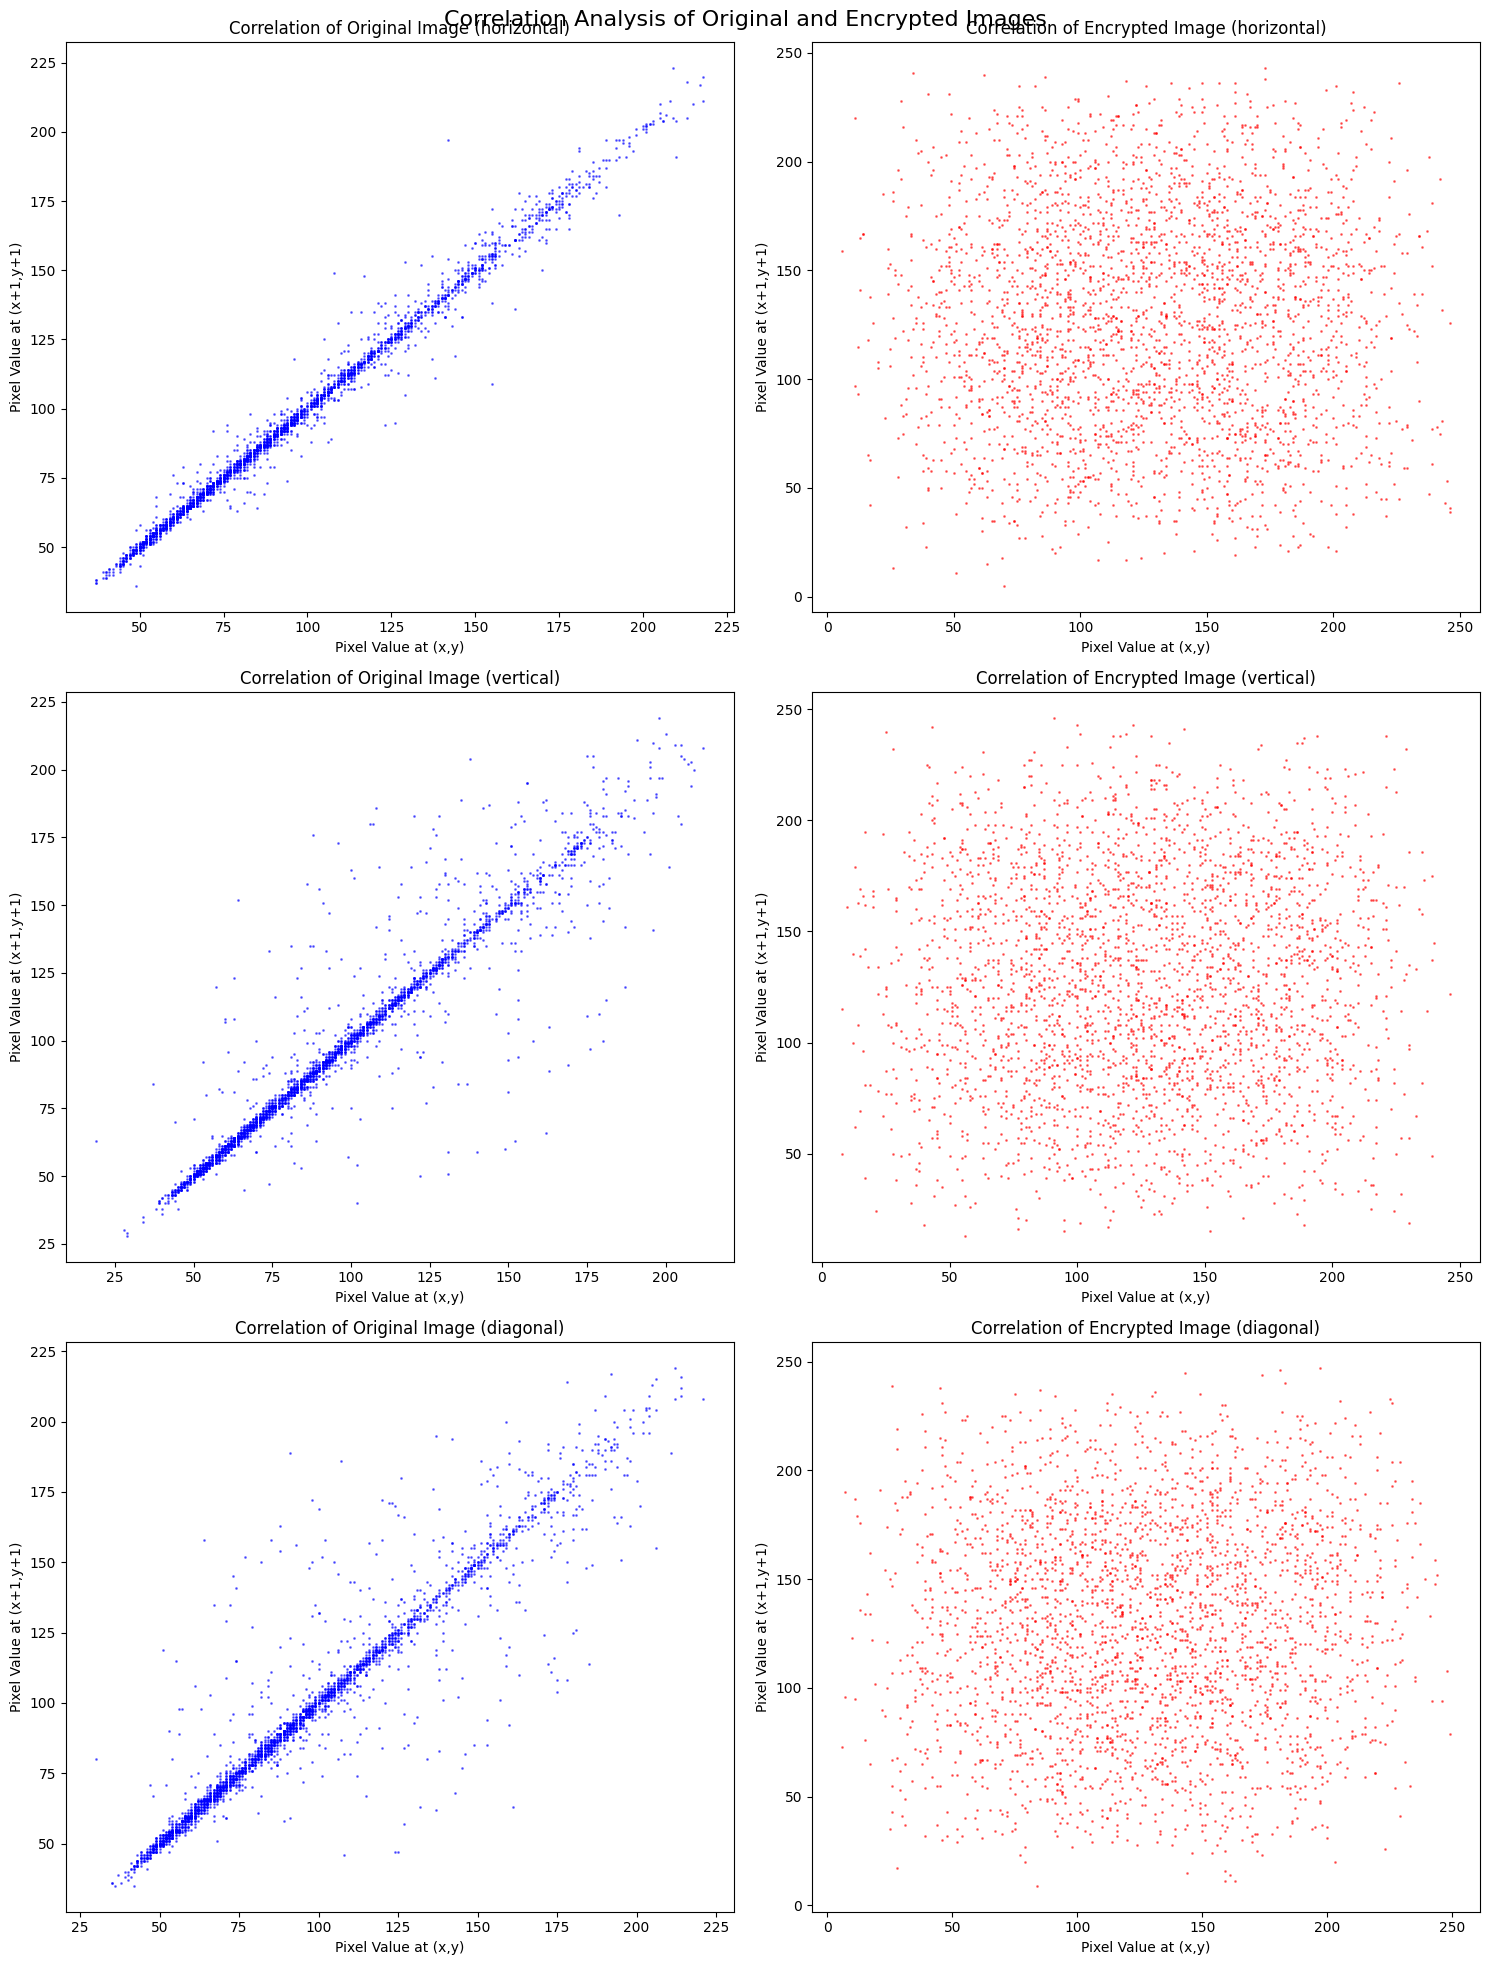

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score
import time
from scipy.stats import entropy
import pandas as pd
from tqdm import tqdm
import os
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes

def encrypt_image(image):
    """
    Encrypt image using AES encryption
    """
    # Convert image to bytes
    image_bytes = image.tobytes()
    
    # Generate random key and IV
    key = get_random_bytes(32)
    cipher = AES.new(key, AES.MODE_CBC)
    
    # Pad the data
    padding_length = 16 - (len(image_bytes) % 16)
    padded_data = image_bytes + bytes([padding_length] * padding_length)
    
    # Encrypt
    encrypted_data = cipher.encrypt(padded_data)
    
    # Convert back to image shape
    encrypted_image = np.frombuffer(encrypted_data[:len(image_bytes)], dtype=np.uint8).reshape(image.shape)
    
    return encrypted_image

def plot_correlation_analysis(original_image, encrypted_image):
    """
    Plot correlation analysis for original and encrypted images
    Shows horizontal, vertical, and diagonal correlations
    """
    def get_correlation_coordinates(image, direction='horizontal', num_points=3000):
        coordinates = []
        rows, cols = image.shape
        
        indices = np.random.choice(rows * cols, min(num_points, rows * cols), replace=False)
        row_indices = indices // cols
        col_indices = indices % cols
        
        if direction == 'horizontal':
            valid_cols = col_indices[col_indices < cols-1]
            coordinates = list(zip(
                image[row_indices[col_indices < cols-1], valid_cols],
                image[row_indices[col_indices < cols-1], valid_cols+1]
            ))
        elif direction == 'vertical':
            valid_rows = row_indices[row_indices < rows-1]
            coordinates = list(zip(
                image[valid_rows, col_indices[row_indices < rows-1]],
                image[valid_rows+1, col_indices[row_indices < rows-1]]
            ))
        elif direction == 'diagonal':
            valid = (row_indices < rows-1) & (col_indices < cols-1)
            coordinates = list(zip(
                image[row_indices[valid], col_indices[valid]],
                image[row_indices[valid]+1, col_indices[valid]+1]
            ))
                    
        return np.array(coordinates)

    # Convert images to grayscale if they're not already
    if len(original_image.shape) == 3:
        original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original_image
        
    if len(encrypted_image.shape) == 3:
        encrypted_gray = cv2.cvtColor(encrypted_image, cv2.COLOR_BGR2GRAY)
    else:
        encrypted_gray = encrypted_image

    # Create figure
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    fig.suptitle('Correlation Analysis of Original and Encrypted Images', fontsize=16)

    directions = ['horizontal', 'vertical', 'diagonal']
    titles = ['Original Image', 'Encrypted Image']
    
    for i, direction in enumerate(directions):
        # Get correlation coordinates
        orig_coords = get_correlation_coordinates(original_gray, direction)
        enc_coords = get_correlation_coordinates(encrypted_gray, direction)
        
        # Plot original image correlation
        axes[i,0].scatter(orig_coords[:,0], orig_coords[:,1], c='blue', alpha=0.5, s=1)
        axes[i,0].set_title(f'Correlation of {titles[0]} ({direction})')
        axes[i,0].set_xlabel('Pixel Value at (x,y)')
        axes[i,0].set_ylabel('Pixel Value at (x+1,y+1)')
        
        # Plot encrypted image correlation
        axes[i,1].scatter(enc_coords[:,0], enc_coords[:,1], c='red', alpha=0.5, s=1)
        axes[i,1].set_title(f'Correlation of {titles[1]} ({direction})')
        axes[i,1].set_xlabel('Pixel Value at (x,y)')
        axes[i,1].set_ylabel('Pixel Value at (x+1,y+1)')
        
        # Calculate and display correlation coefficients
        orig_corr = np.corrcoef(orig_coords[:,0], orig_coords[:,1])[0,1]
        enc_corr = np.corrcoef(enc_coords[:,0], enc_coords[:,1])[0,1]
        print(f"{direction.capitalize()} correlation coefficient:")
        print(f"Original image: {orig_corr:.4f}")
        print(f"Encrypted image: {enc_corr:.4f}\n")

    plt.tight_layout()
    plt.show()

# Test the correlation analysis
test_image = cv2.imread("test/real/real_image1.jpg")
if test_image is None:
    raise ValueError("Could not load test image. Please check the path.")

# Encrypt the image
encrypted_image = encrypt_image(test_image)

# Plot correlation analysis
plot_correlation_analysis(test_image, encrypted_image)


Entropy Analysis:
Original Image Entropy: 7.0621 bits/pixel
Encrypted Image Entropy: 7.6328 bits/pixel


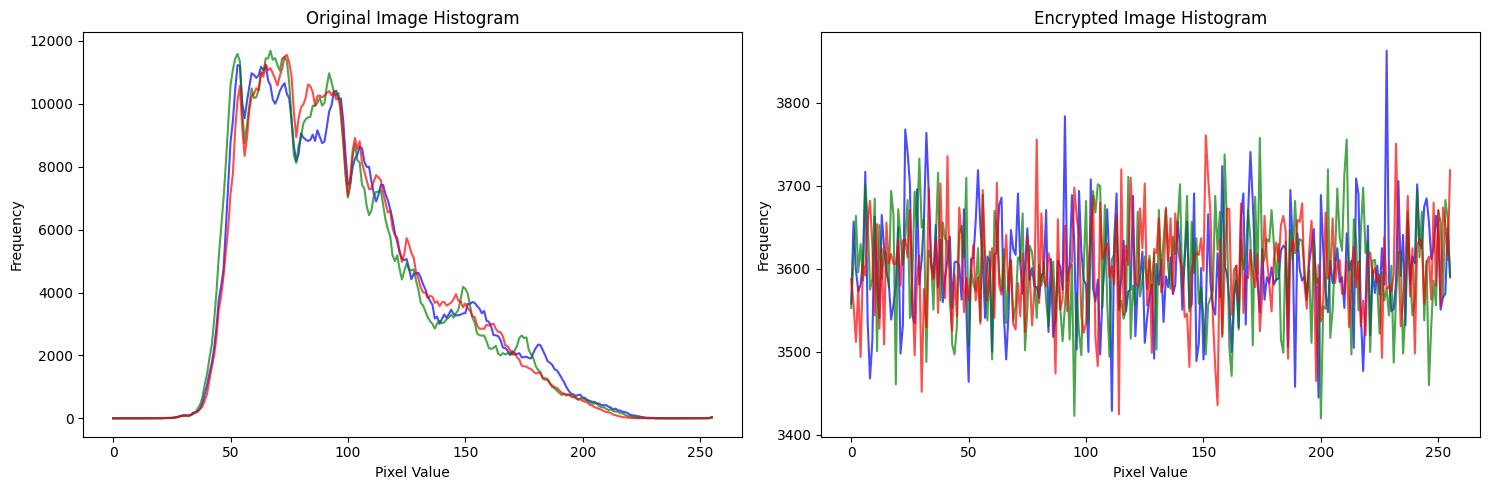


Statistical Analysis:
Original Image - Mean: [98.76985135 95.79584744 97.77136502], Std: [38.33435992 37.32733464 36.07740064]
Encrypted Image - Mean: [127.5125     127.44698893 127.5649566 ], Std: [73.96837244 73.93743255 73.8943162 ]
Horizontal correlation coefficient:
Original image: 0.9937
Encrypted image: 0.0095

Vertical correlation coefficient:
Original image: 0.9458
Encrypted image: -0.0163

Diagonal correlation coefficient:
Original image: 0.9462
Encrypted image: 0.0043



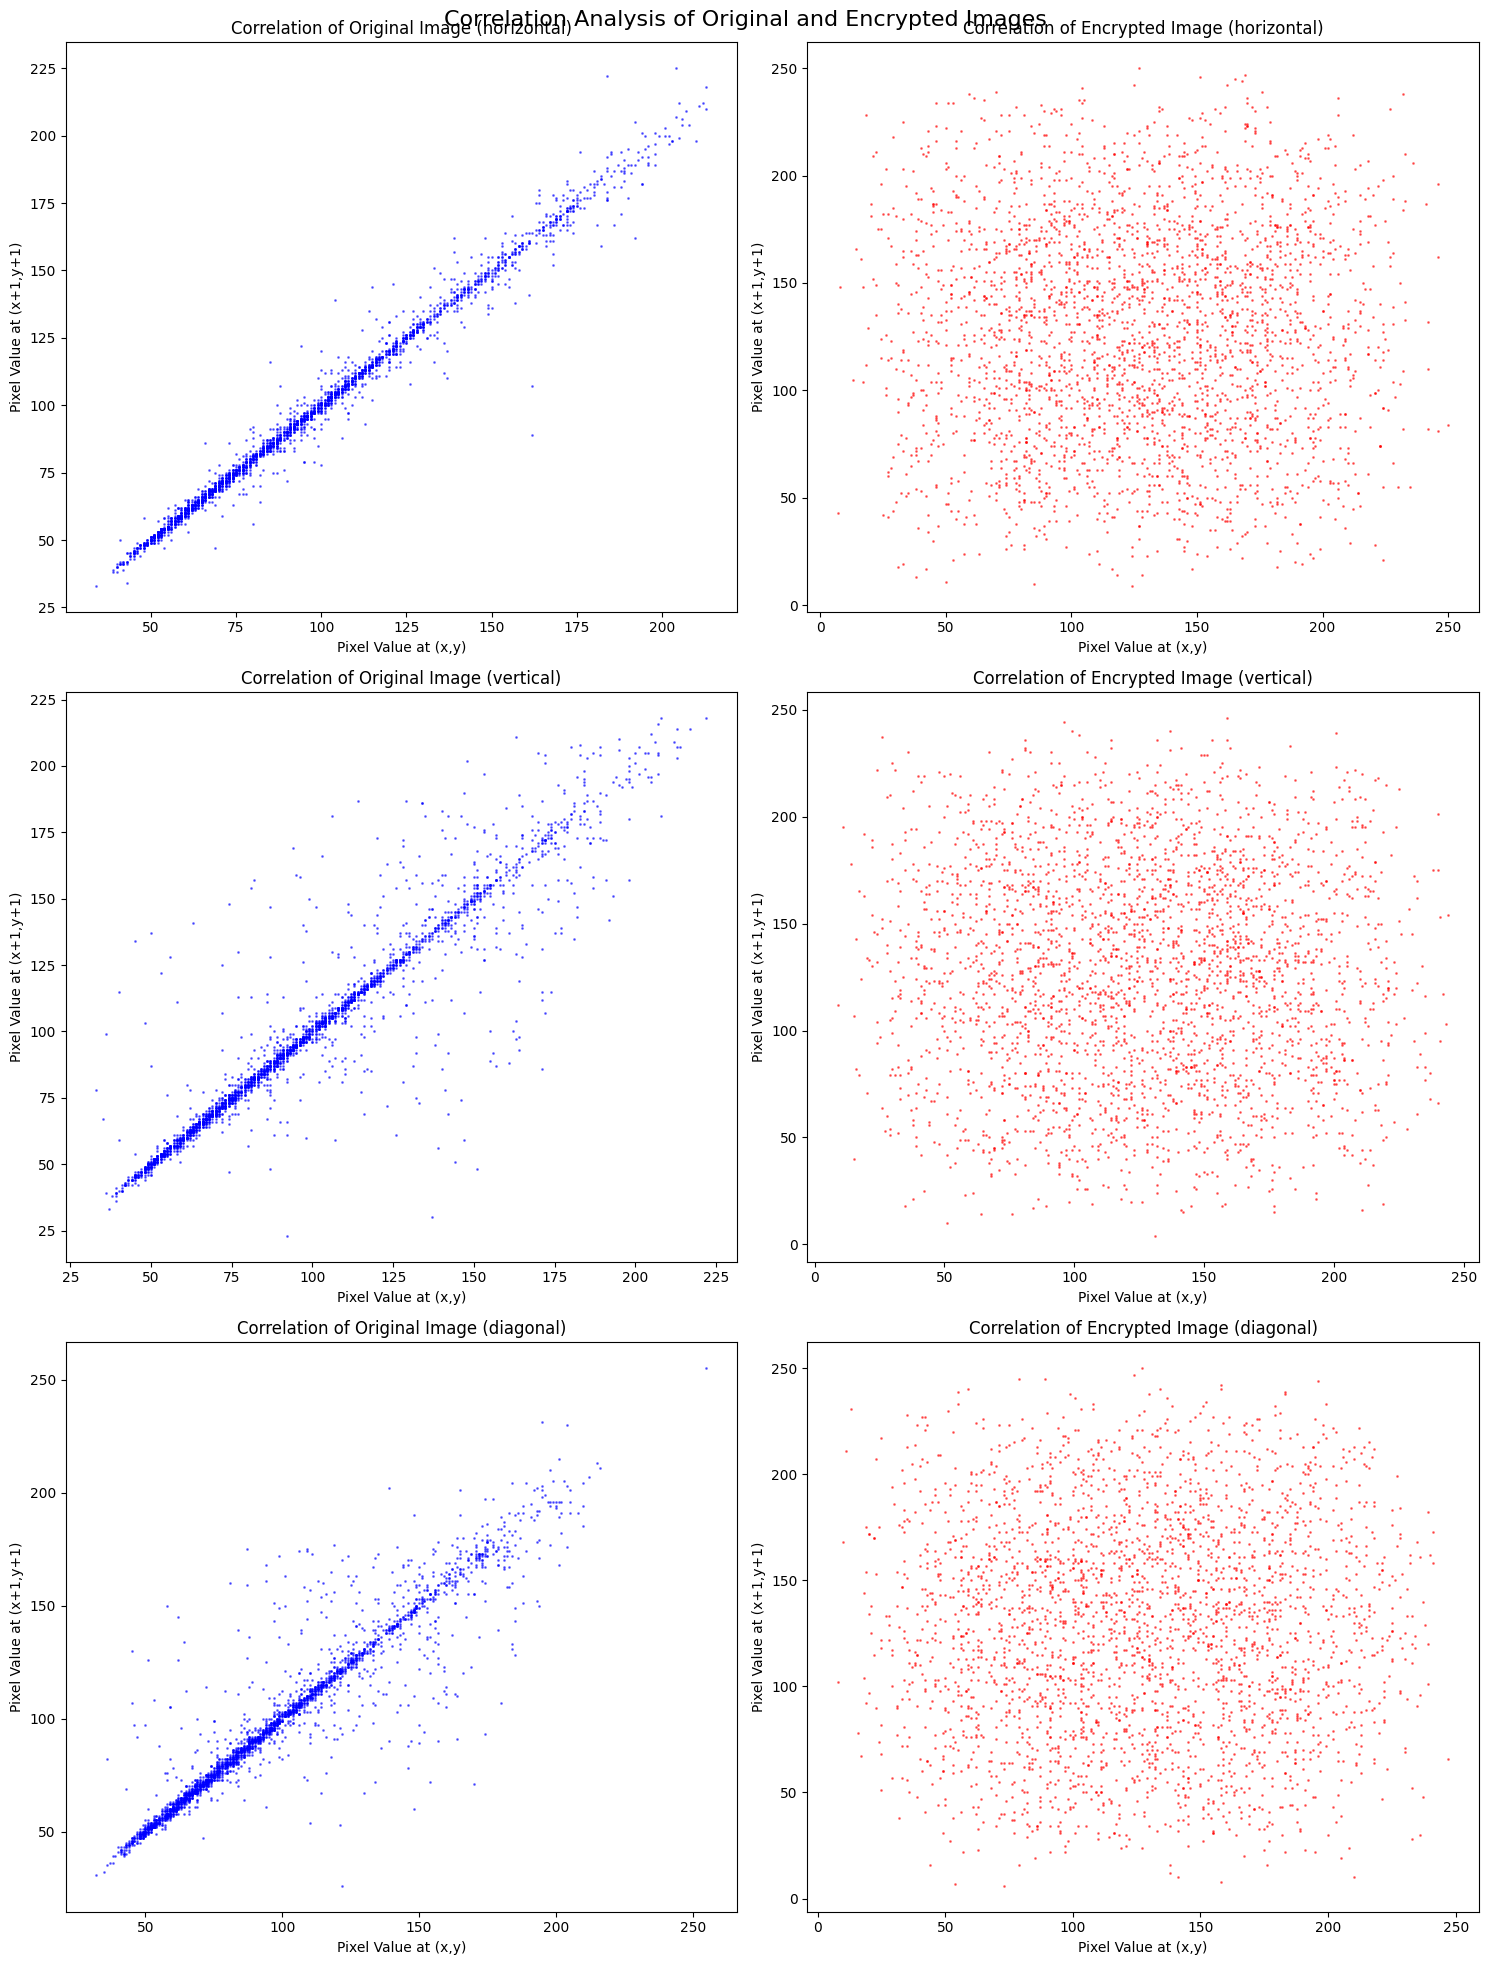

In [2]:
def calculate_entropy(image):
    """
    Calculate the entropy of an image
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    
    # Convert histogram to probabilities
    hist = hist.ravel() / hist.sum()
    
    # Remove zero probabilities
    hist = hist[hist != 0]
    
    # Calculate entropy
    entropy_value = -np.sum(hist * np.log2(hist))
    
    return entropy_value

def analyze_encryption_quality(original_image, encrypted_image):
    """
    Analyze the encryption quality using entropy and histogram analysis
    """
    # Calculate entropies
    original_entropy = calculate_entropy(original_image)
    encrypted_entropy = calculate_entropy(encrypted_image)
    
    print("\nEntropy Analysis:")
    print(f"Original Image Entropy: {original_entropy:.4f} bits/pixel")
    print(f"Encrypted Image Entropy: {encrypted_entropy:.4f} bits/pixel")
    
    # Create histograms
    plt.figure(figsize=(15, 5))
    
    # Original image histogram
    plt.subplot(121)
    if len(original_image.shape) == 3:
        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([original_image], [i], None, [256], [0, 256])
            plt.plot(hist, color=color, alpha=0.7)
    else:
        hist = cv2.calcHist([original_image], [0], None, [256], [0, 256])
        plt.plot(hist, 'k', alpha=0.7)
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # Encrypted image histogram
    plt.subplot(122)
    if len(encrypted_image.shape) == 3:
        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([encrypted_image], [i], None, [256], [0, 256])
            plt.plot(hist, color=color, alpha=0.7)
    else:
        hist = cv2.calcHist([encrypted_image], [0], None, [256], [0, 256])
        plt.plot(hist, 'k', alpha=0.7)
    plt.title('Encrypted Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate additional metrics
    if len(original_image.shape) == 3:
        original_mean = np.mean(original_image, axis=(0,1))
        encrypted_mean = np.mean(encrypted_image, axis=(0,1))
        original_std = np.std(original_image, axis=(0,1))
        encrypted_std = np.std(encrypted_image, axis=(0,1))
    else:
        original_mean = np.mean(original_image)
        encrypted_mean = np.mean(encrypted_image)
        original_std = np.std(original_image)
        encrypted_std = np.std(encrypted_image)
    
    print("\nStatistical Analysis:")
    print(f"Original Image - Mean: {original_mean}, Std: {original_std}")
    print(f"Encrypted Image - Mean: {encrypted_mean}, Std: {encrypted_std}")
    
    return {
        'original_entropy': original_entropy,
        'encrypted_entropy': encrypted_entropy,
        'original_mean': original_mean,
        'encrypted_mean': encrypted_mean,
        'original_std': original_std,
        'encrypted_std': encrypted_std
    }

# Test the encryption quality analysis
test_image = cv2.imread("test/real/real_image1.jpg")
if test_image is None:
    raise ValueError("Could not load test image. Please check the path.")

# Encrypt the image using proper encryption
encrypted_image = encrypt_image(test_image)

# Analyze encryption quality
encryption_metrics = analyze_encryption_quality(test_image, encrypted_image)

# Plot correlation analysis
plot_correlation_analysis(test_image, encrypted_image)